# Ideal Parameter Analysis ($\delta=1$, $\tau=0.75$, $\alpha=2$) ($\delta$ lower bound, $\tau$ lower bound)

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sys

from datetime import datetime

sys.path.append('../../feeg_fmri_sync')

from feeg_fmri_sync.plotting import (
    plot_all_search_results_2d,
    plot_local_minima
)
from feeg_fmri_sync.search import (
    build_models,
    search_voxels
)
from feeg_fmri_sync.simulations import (
    build_model_to_fmri,
    generate_downsampled_simulated_fmri,
)
from feeg_fmri_sync.utils import (
    generate_descriptions_from_search_df,
)
from feeg_fmri_sync.vectorized_models import VectorizedHemodynamicModel

In [2]:
try_to_reuse = True
submit_to_cluster = False

## Initialize constants for Hemodynamic Modeling

In [3]:
### Initialize constants ###
sample_freq = 20
tr = 800
n_trs_skipped_at_beginning = 0
hemodynamic_response_window = 30

# Actual Values to generate data from
expected_delta = 1
expected_tau=0.75
expected_alpha=2

## Initialize constants for simulation

In [4]:
# Plot the generated data
# NOTE: only the first of the trials will be plotted
plot_generated_data = True

# Plot perfect data when modeling
plot_perfect_comparison = True

# noises to examine and plot when modeling
noise_range = range(1, 11)  
noises_to_plot = [3, 5, 10]

# trials we run for each condition and how many trials to plot when modeling
num_trials = 100  
num_trials_to_plot = 1

# models to examine
models_to_test = [
    {
        'name': 'downsample',
        'model': VectorizedHemodynamicModel,
        'fmri_data_generator': generate_downsampled_simulated_fmri,
    }
]

# eeg data types to use
eeg_data_options_for_fmri_generation = ['without_nans']
eeg_data_options_for_simulation = ['without_nans', 'with_nans']

## Display Generated Noise against Simulated Ground Truth

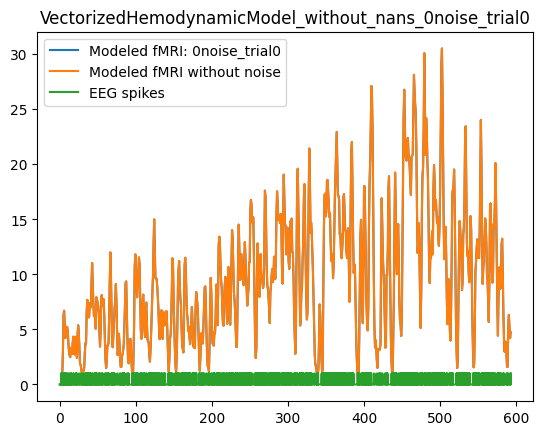

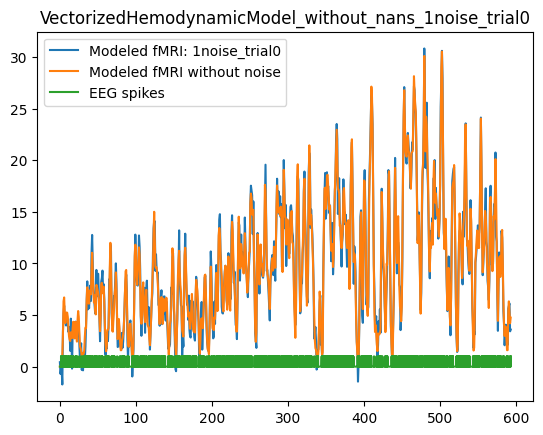

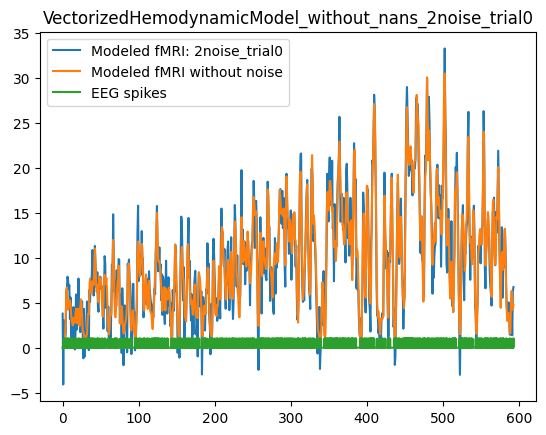

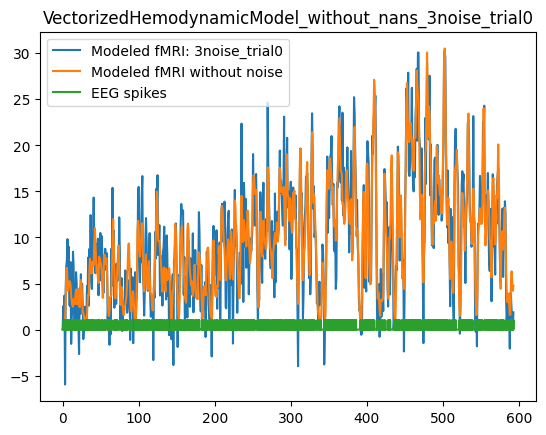

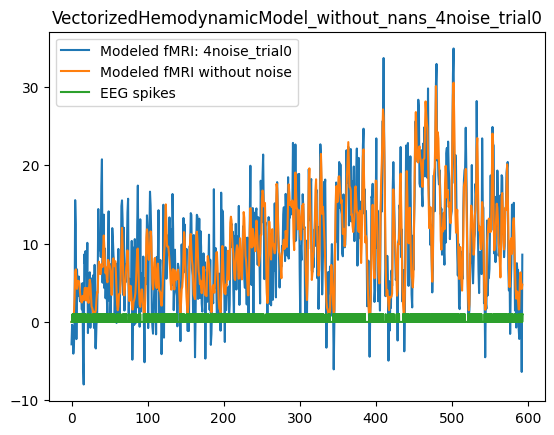

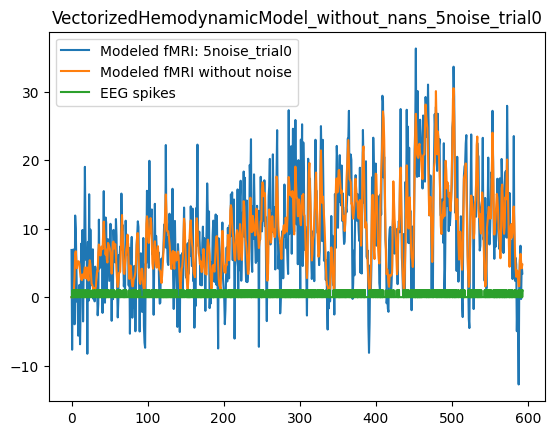

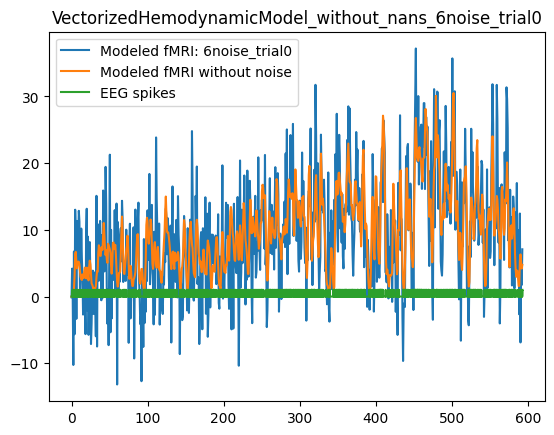

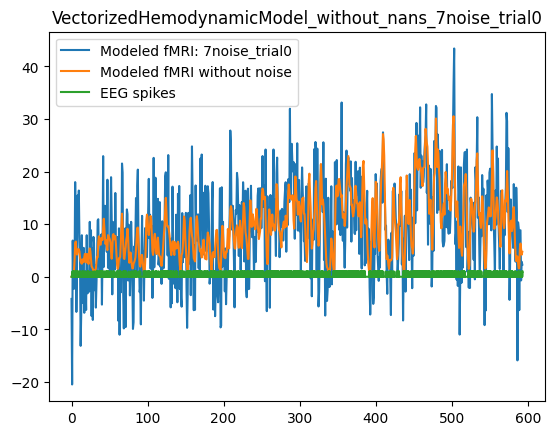

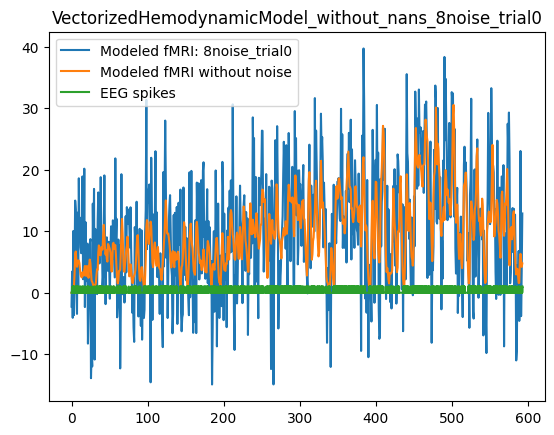

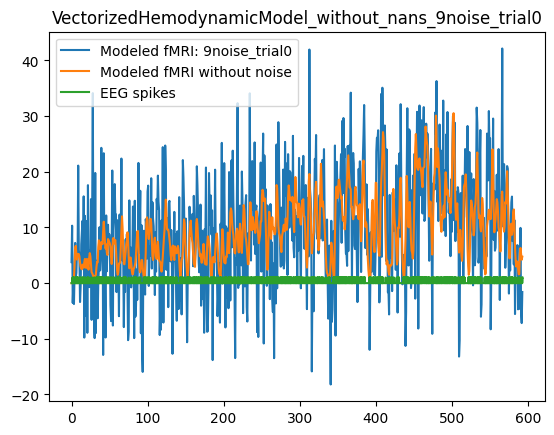

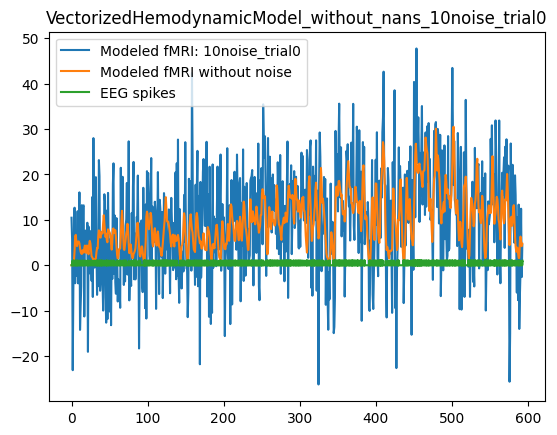

In [5]:
# Generate fMRI data
model_to_fmri = build_model_to_fmri(
    models_to_test,
    eeg_data_options_for_fmri_generation,
    expected_delta,
    expected_tau,
    expected_alpha,
    num_trials,
    num_trials_to_plot,
    noise_range,
    noises_to_plot,
    plot_perfect_comparison,
    tr,
    sample_freq,
    hemodynamic_response_window,
    plot_generated_data
)


## Initialize Analysis variables

In [6]:
step_size = 0.05

filename_substring = f'effect_of_ideal_params_delta{expected_delta}_tau{expected_tau}_alpha{expected_alpha}'
filename_ext = '.csv'
plot = True

delta = np.arange(1, 3+step_size, step_size)
tau = np.arange(0.75, 1.75+step_size, step_size)
alpha = np.arange(1.75, 2.25+step_size, step_size)

print(f'Delta target: {expected_delta}, Range:\n{delta}\n')
print(f'Tau target: {expected_tau}, Range:\n{tau}\n')
print(f'Alpha target: {expected_alpha}, Range:\n{alpha}\n')

Delta target: 1, Range:
[1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65
 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35
 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.  ]

Tau target: 0.75, Range:
[0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75]

Alpha target: 2, Range:
[1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25]



## Est vs Actual for all models at correct points

Scoring downsample_without_nans_without_nans delta=1, tau=0.75, alpha=2


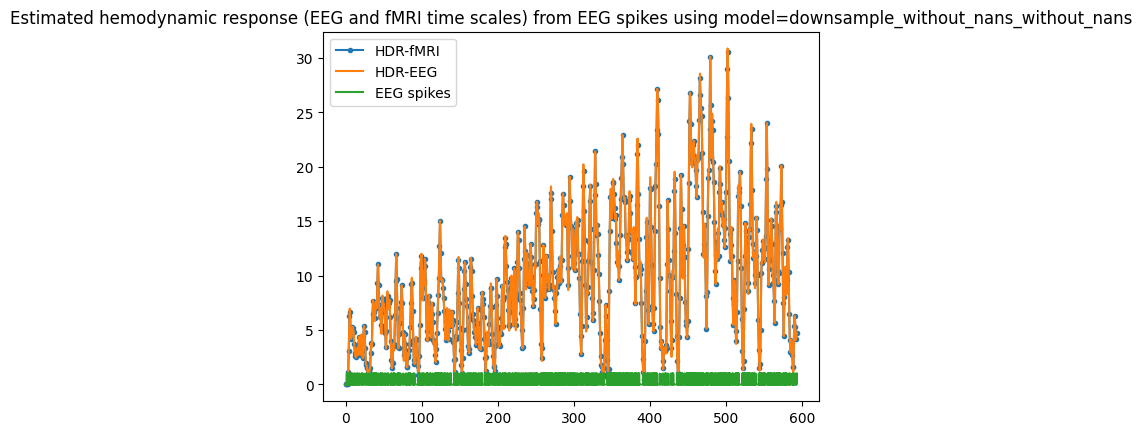

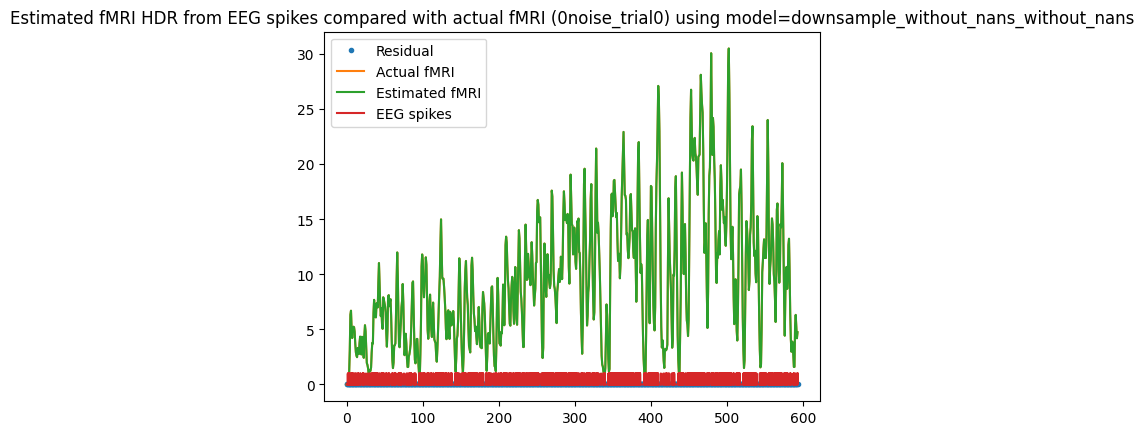

Residual Variance is 0.000000


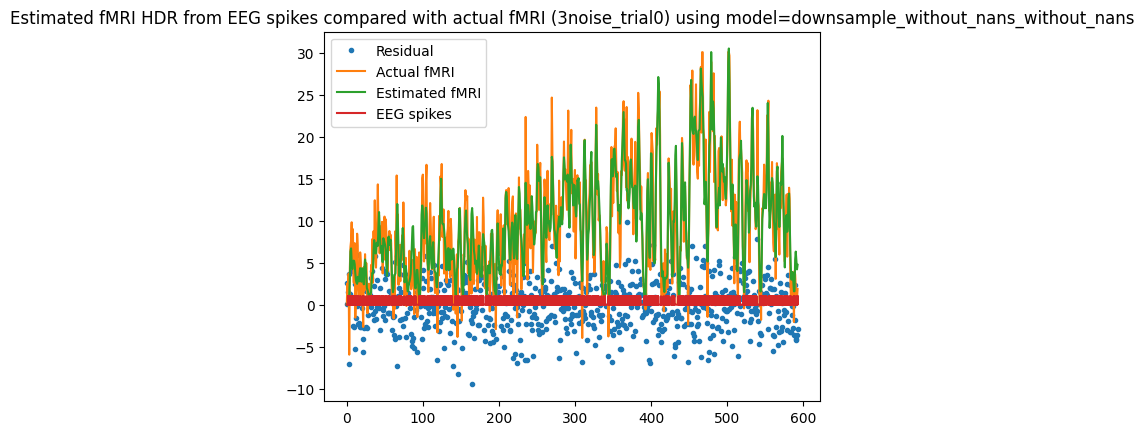

Residual Variance is 8.725084


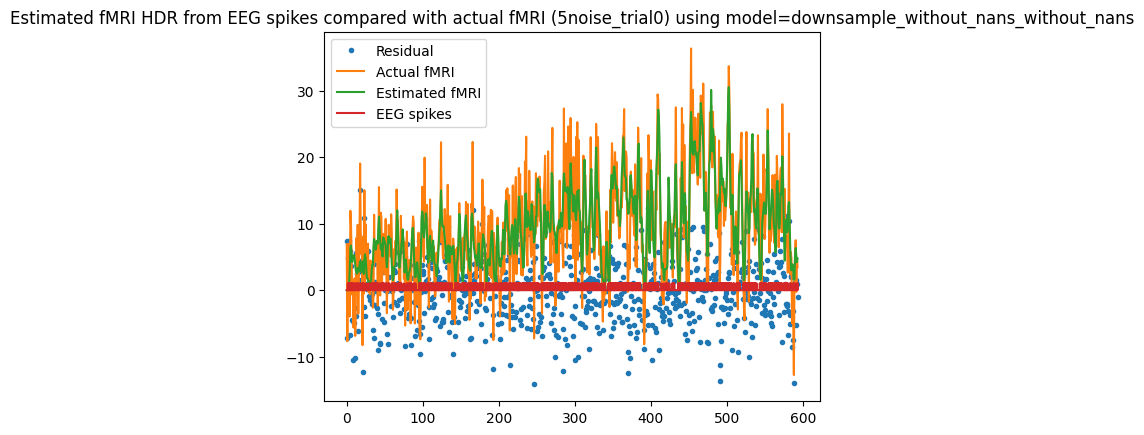

Residual Variance is 22.930182


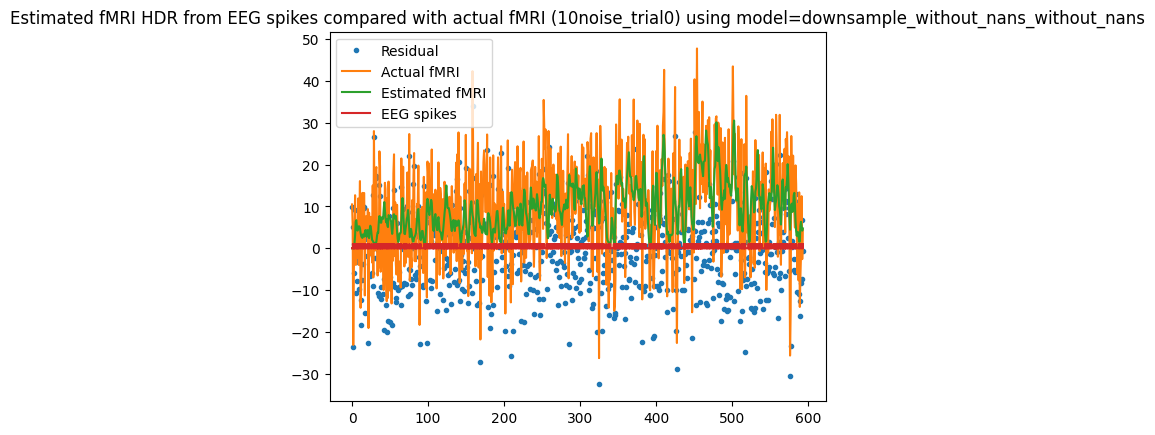

Residual Variance is 103.394231


Scoring downsample_without_nans_with_nans delta=1, tau=0.75, alpha=2


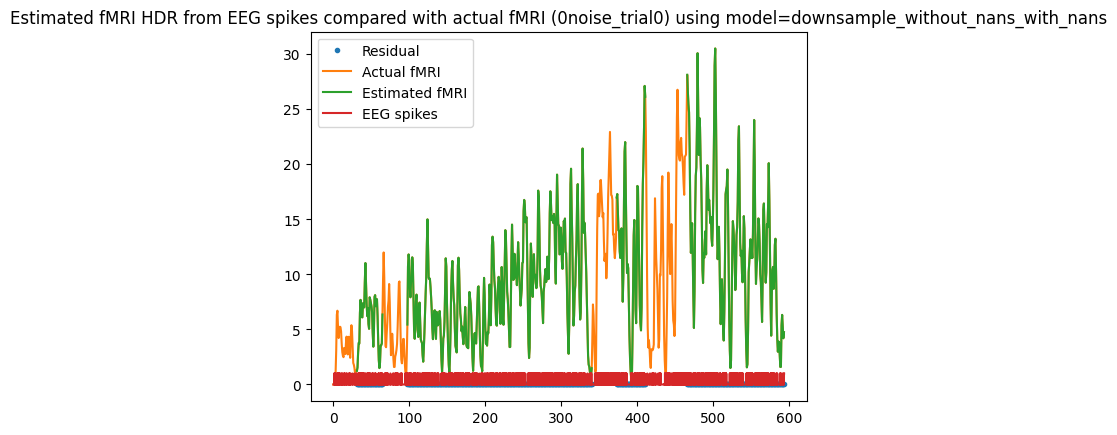

Residual Variance is 0.000000


Residual Variance is 8.519177


Residual Variance is 22.444918


Residual Variance is 103.188016


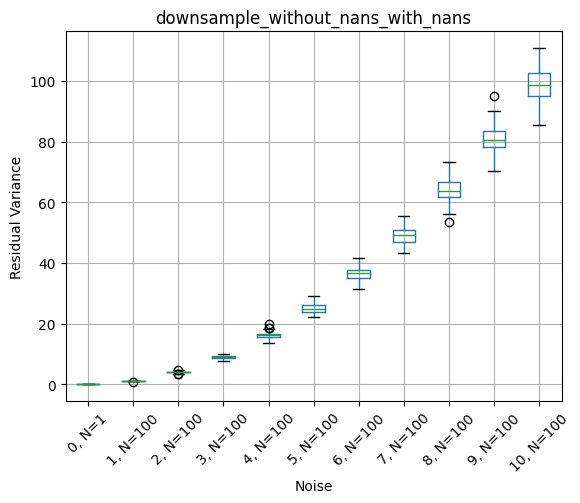

In [7]:
models = build_models(
    model_to_fmri,
    eeg_data_options_for_simulation,
    tr, 
    n_trs_skipped_at_beginning,
    sample_freq,
    hemodynamic_response_window,
    plot
)

# Get in-depth plots for actual delta, tau, alpha
for model_name, model in models.items():
    residual_var = model.score(expected_delta, expected_tau, expected_alpha)
    fmri_names = np.array(model.fmri.voxel_names)
    if (fmri_names == None).any():
        print(f'Residual variance was {residual_var}')
    else:
        noise_levels = np.char.replace(fmri_names, 'perfect', '0noise_trail0')
        noise_levels = np.char.partition(noise_levels, sep='noise')
        res_var_df = pd.DataFrame(zip(noise_levels[:,0].astype(int), residual_var), columns=['Noise', 'res_var'])
        res_var_by_noise = res_var_df.groupby('Noise')
        _, axs = plt.subplots()
        axs.set_title(model_name)
        axs.set_ylabel('Residual Variance')
        axs.set_xlabel('Noise')
        axs = res_var_by_noise.boxplot(column='res_var', subplots=False, rot=45, ax=axs)
        labels = res_var_by_noise.count()
        labels = [f'{noise}, N={n.item()}' for noise, n in zip(labels.index, labels.values)]
        plt.setp(axs, xticklabels=labels)
        plt.show()
    model.plot = False

## Generate/Load the full dataset

In [8]:
# Optional Reuse functionality

df = pd.DataFrame()
descriptions = []

if try_to_reuse:
    matching_files = sorted(glob.glob(f'{filename_substring}*{filename_ext}'))
    filename_to_use = "none"
    if len(matching_files) != 0:
        filename_to_use = input(
            f'Found previously run data. Enter name to reuse or "none" to recalculate.'
            f'\n{matching_files}\nDefault ({matching_files[-1]})\n'
        )
    if filename_to_use.lower() != "none":
        if filename_to_use.strip() == '':
            filename_to_use = matching_files[-1]
        print(f'Loading data from {filename_to_use}...')
        with open(filename_to_use, 'r') as f:
            df = pd.read_csv(f, index_col=0)
        descriptions = generate_descriptions_from_search_df(df, models)


In [9]:
if df.empty:
    if submit_to_cluster:
        raise NotImplemented("Submitting to the cluster is not implemented!")
    print('Generating data!')
    descriptions, df = search_voxels(models, delta, tau, alpha)
    with open(f'{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
        pd.DataFrame(df).to_csv(f)
    for model_name, description in zip(models.keys(), descriptions):
        with open(f'{model_name}_summary_{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
            pd.DataFrame(description).transpose().to_csv(f)

df

Generating data!
Scoring delta=1.0
Scoring delta=1.05
Scoring delta=1.1
Scoring delta=1.1500000000000001
Scoring delta=1.2000000000000002
Scoring delta=1.2500000000000002
Scoring delta=1.3000000000000003
Scoring delta=1.3500000000000003
Scoring delta=1.4000000000000004
Scoring delta=1.4500000000000004
Scoring delta=1.5000000000000004
Scoring delta=1.5500000000000005
Scoring delta=1.6000000000000005
Scoring delta=1.6500000000000006
Scoring delta=1.7000000000000006
Scoring delta=1.7500000000000007
Scoring delta=1.8000000000000007
Scoring delta=1.8500000000000008
Scoring delta=1.9000000000000008
Scoring delta=1.9500000000000008
Scoring delta=2.000000000000001
Scoring delta=2.0500000000000007
Scoring delta=2.100000000000001
Scoring delta=2.1500000000000012
Scoring delta=2.200000000000001
Scoring delta=2.250000000000001
Scoring delta=2.300000000000001
Scoring delta=2.3500000000000014
Scoring delta=2.4000000000000012
Scoring delta=2.450000000000001
Scoring delta=2.5000000000000013
Scoring de

delta                 tau               alpha  \
0                     1.0                0.75                1.75   
1                     1.0                0.75                1.75   
2                     1.0                0.75                 1.8   
3                     1.0                0.75                 1.8   
4                     1.0                0.75                1.85   
...                   ...                 ...                 ...   
18937  3.0000000000000018  1.7500000000000009  2.1500000000000004   
18938  3.0000000000000018  1.7500000000000009                 2.2   
18939  3.0000000000000018  1.7500000000000009                 2.2   
18940  3.0000000000000018  1.7500000000000009  2.2500000000000004   
18941  3.0000000000000018  1.7500000000000009  2.2500000000000004   

                                 model_name        0noise_trial0  \
0      downsample_without_nans_without_nans   0.2967172436941686   
1         downsample_without_nans_with_nans  0.29777035426497583   
2      downsample_without_nans_without_nans  0.18803144341166603   
3         downsample_without_nans_with_nans  0.18867667419530276   
4      downsample_without_nans_without_nans   0.1047014217351073   
...                                     ...                  ...   
18937     downsample_without_nans_with_nans   23.884082601515253   
18938  downsample_without_nans_without_nans    25.47453326448669   
18939     downsample_without_nans_with_nans    23.96118783130631   
18940  downsample_without_nans_without_nans   25.574656638954703   
18941     downsample_without_nans_with_nans    24.03275747893375   

            1noise_trial0       2noise_trial0       3noise_trial0  \
0       1.350891715839512   4.128798075512192   9.189526738696694   
1      1.3350893689589098   4.036546273474301   8.974494566046719   
2      1.2367422603050293   4.037133069635907   9.045232360152776   
3       1.226144086142995  3.9507077279595446      8.829883279304   
4       1.148229174044875   3.972429311759758   8.927225906968724   
...                   ...                 ...                 ...   
18937  25.264389362410594    29.6633841919515  32.817235980772644   
18938  26.510672275508345  31.505507231966014  34.084683436185514   
18939  25.337760563927155  29.729530320807545  32.888836162510216   
18940  26.607075925982862  31.599261158805476  34.179949435121266   
18941   25.40564368978464  29.790026614092973  32.955264089491514   

            4noise_trial0       5noise_trial0  ...      1noise_trial99  \
0      18.206173681742104   23.39953244035154  ...   1.304892728271885   
1      18.539630679182306  22.939077123131078  ...  1.2970124517765815   
2      18.079170768459644  23.245732998324826  ...  1.1855866588815005   
3      18.399327665034104  22.779859414168918  ...  1.1775022427611561   
4       17.97717354693509    23.1227038544516  ...  1.0913038612293937   
...                   ...                 ...  ...                 ...   
18937   39.60174214746602   48.51079030025533  ...   24.47606238942382   
18938   41.54807758711941   50.92615907196826  ...   26.11313193843069   
18939   39.68523323194168    48.5915042269797  ...  24.560522413311347   
18940   41.64703762183768  51.025177732089354  ...  26.218817924523602   
18941   39.76359275689788  48.666382988127744  ...  24.639391723043428   

           2noise_trial99      3noise_trial99      4noise_trial99  \
0       4.476314286325591   9.361473347044033  16.396706636563888   
1       4.507170575435719   8.887255195885157   16.86758235880195   
2       4.367849065902522   9.255774817296256  16.347708838078262   
3       4.401204857255974   8.782884716749034  16.811221866968665   
4       4.283871504605461   9.176353662077517    16.3242570382074   
...                   ...                 ...                 ...   
18937  27.145376350003854  31.242960496600546   42.21500296435121   
18938   29.17299008581633   33.74520399347575   44.19603879431823   
18939  27.223656485038045  31.30185

## No Noise Analysis - downsample without missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_without_nans) = 4.2903493722532786e-29; at
    delta   tau  alpha
10    1.0  0.75    2.0


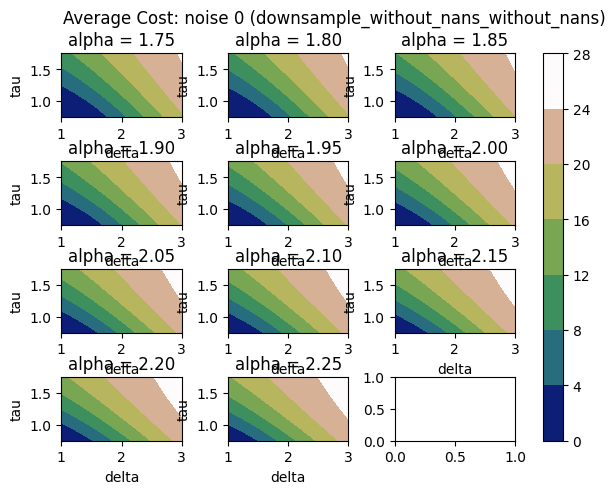

delta   tau  alpha  \
0        1.0  0.75   1.75   
2        1.0  0.75   1.80   
4        1.0  0.75   1.85   
6        1.0  0.75   1.90   
8        1.0  0.75   1.95   
...      ...   ...    ...   
18932    3.0  1.75   2.05   
18934    3.0  1.75   2.10   
18936    3.0  1.75   2.15   
18938    3.0  1.75   2.20   
18940    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_without_nans)  
0                                               0.296717             
2                                               0.188031             
4                                               0.104701             
6                                               0.046054             
8                                               0.011392             
...                                                  ...             
18932                                          25.135710             
18934                                          25.255319             
18936                                          25.368173             
18938                                          25.474533             
18940                                          25.574657             

[9471 rows x 4 columns]

In [10]:
model_name = 'downsample_without_nans_without_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [11]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 1, Tau target: 0.75, Alpha target: 2


delta   tau  alpha
0    1.0  0.75    2.0

### Local Minima Analysis

In [12]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 1, Tau target: 0.75, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  4.290349e-29   1.00  0.75    2.0
1      0         0  5.149306e-03   1.05  0.80    1.8

In [13]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         2.0

#### Local minima at edges

In [14]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

noise iteration          cost  delta   tau  alpha
0      0         0  4.290349e-29    1.0  0.75    2.0

In [15]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [16]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

noise iteration          cost  delta   tau  alpha
0      0         0  4.290349e-29    1.0  0.75    2.0

In [17]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [18]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [19]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## No Noise Analysis - downsample with missing data

### Cost

In [20]:
model_name = 'downsample_without_nans_with_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


Minimal Cost for Average Cost: noise 0 (downsample_without_nans_with_nans) = 2.9657777613452485e-29; at
    delta   tau  alpha
11    1.0  0.75    2.0


delta   tau  alpha  \
1        1.0  0.75   1.75   
3        1.0  0.75   1.80   
5        1.0  0.75   1.85   
7        1.0  0.75   1.90   
9        1.0  0.75   1.95   
...      ...   ...    ...   
18933    3.0  1.75   2.05   
18935    3.0  1.75   2.10   
18937    3.0  1.75   2.15   
18939    3.0  1.75   2.20   
18941    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_with_nans)  
1                                               0.297770          
3                                               0.188677          
5                                               0.105049          
7                                               0.046202          
9                                               0.011427          
...                                                  ...          
18933                                          23.712249          
18935                                          23.801190          
18937                                          23.884083          
18939                                          23.961188          
18941                                          24.032757          

[9471 rows x 4 columns]

In [21]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 1, Tau target: 0.75, Alpha target: 2


delta   tau  alpha
0    1.0  0.75    2.0

### Local Minima Analysis

In [22]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 1, Tau target: 0.75, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  2.965778e-29   1.00  0.75    2.0
1      0         0  4.867102e-03   1.05  0.80    1.8

In [23]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         2.0

#### Local minima at edges

In [24]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

noise iteration          cost  delta   tau  alpha
0      0         0  2.965778e-29    1.0  0.75    2.0

In [25]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [26]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

noise iteration          cost  delta   tau  alpha
0      0         0  2.965778e-29    1.0  0.75    2.0

In [27]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [28]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [29]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## Cost by Noise

### Downsample without Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_without_nans) = 0.9985491333230884; at
    delta   tau  alpha
10    1.0  0.75    2.0


Minimal Cost for Average Cost: noise 2 (downsample_without_nans_without_nans) = 4.032615565398674; at
    delta   tau  alpha
10    1.0  0.75    2.0


Minimal Cost for Average Cost: noise 3 (downsample_without_nans_without_nans) = 8.900498157798824; at
    delta   tau  alpha
10    1.0  0.75    2.0


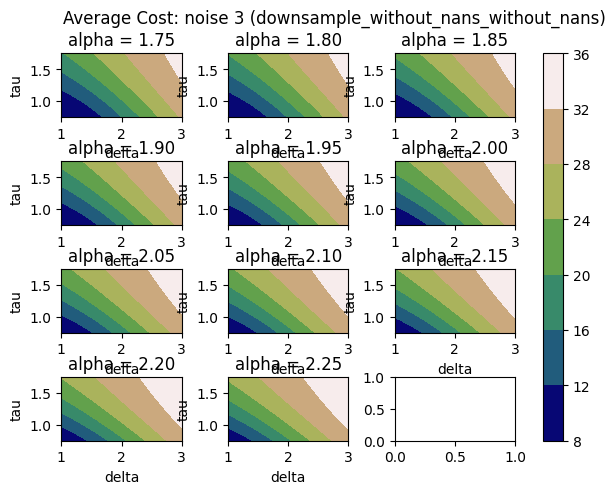

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_without_nans) = 16.054890001695966; at
    delta   tau  alpha
10    1.0  0.75    2.0


Minimal Cost for Average Cost: noise 5 (downsample_without_nans_without_nans) = 25.057801381791595; at
    delta   tau  alpha
10    1.0  0.75    2.0


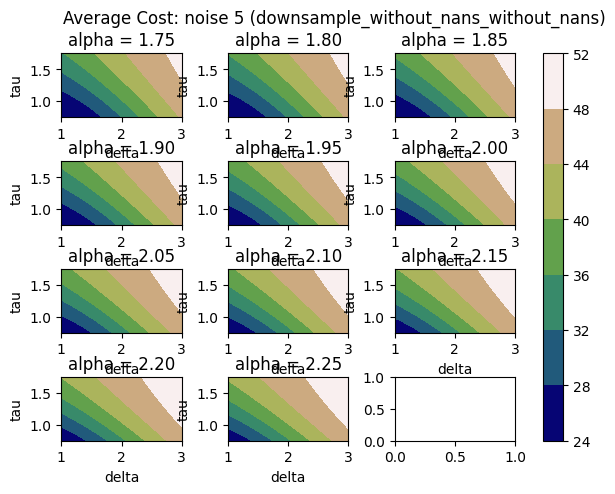

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_without_nans) = 36.27399413768868; at
    delta   tau  alpha
10    1.0  0.75    2.0


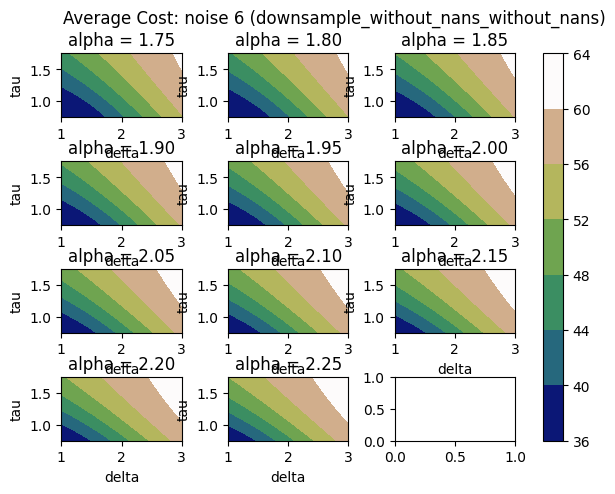

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_without_nans) = 49.09582801018244; at
     delta   tau  alpha
468   1.05  0.75    1.9


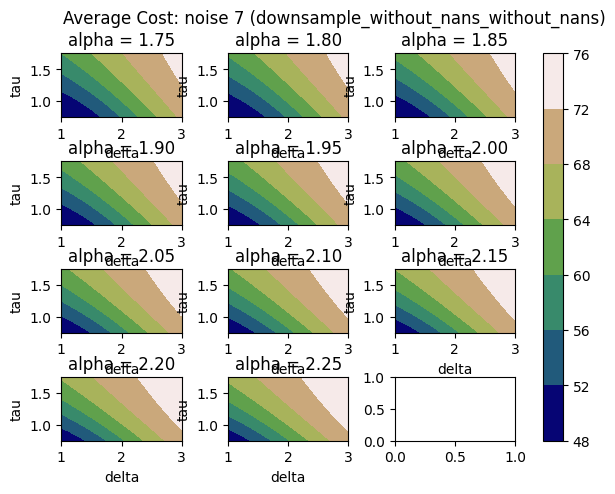

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_without_nans) = 64.162683546449; at
    delta   tau  alpha
10    1.0  0.75    2.0


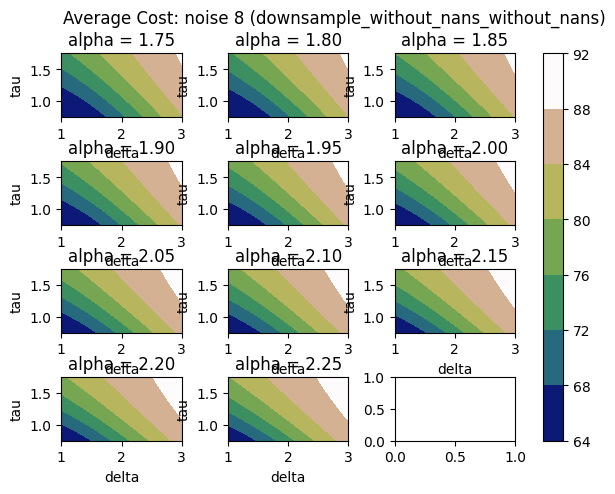

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_without_nans) = 80.99637529856778; at
     delta  tau  alpha
486   1.05  0.8    1.8


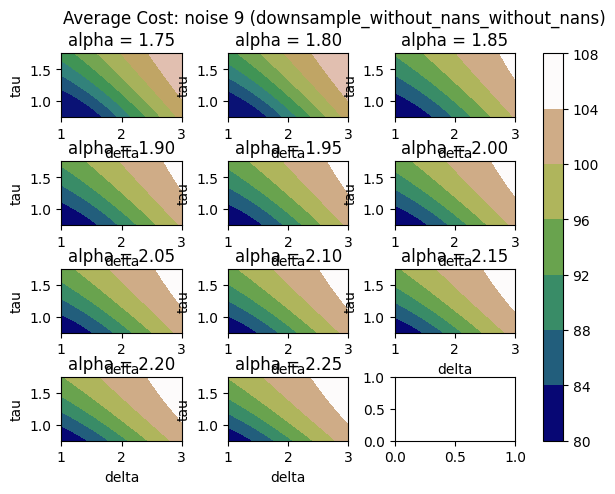

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_without_nans) = 98.96518487161534; at
     delta   tau  alpha
468   1.05  0.75    1.9


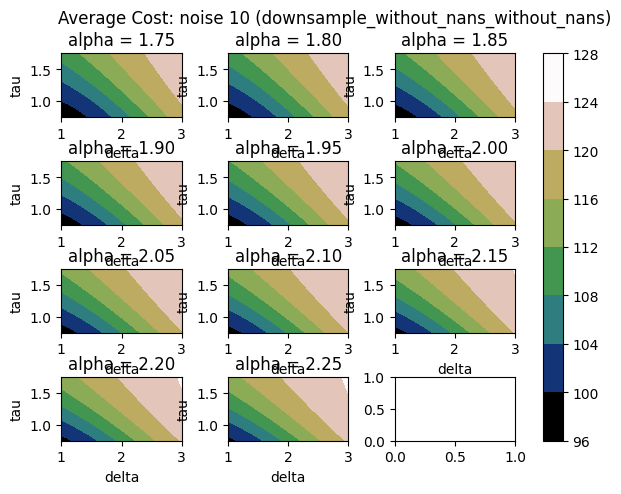

In [30]:
model_name = 'downsample_without_nans_without_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')

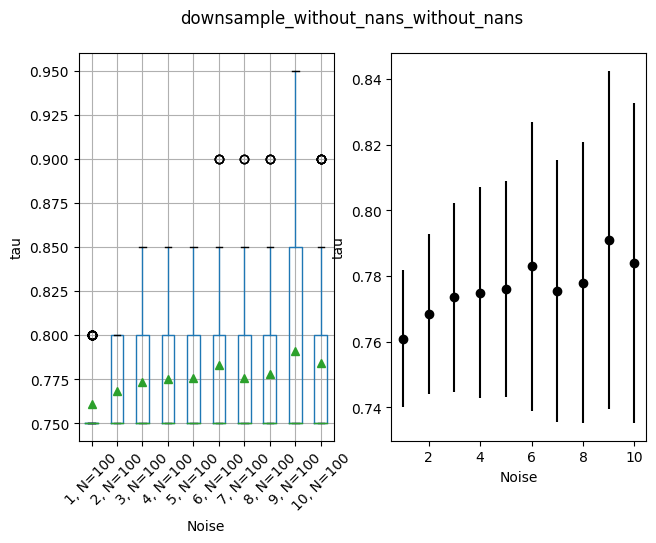

In [31]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

### Downsample with Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_with_nans) = 1.0017505205266208; at
    delta   tau  alpha
11    1.0  0.75    2.0


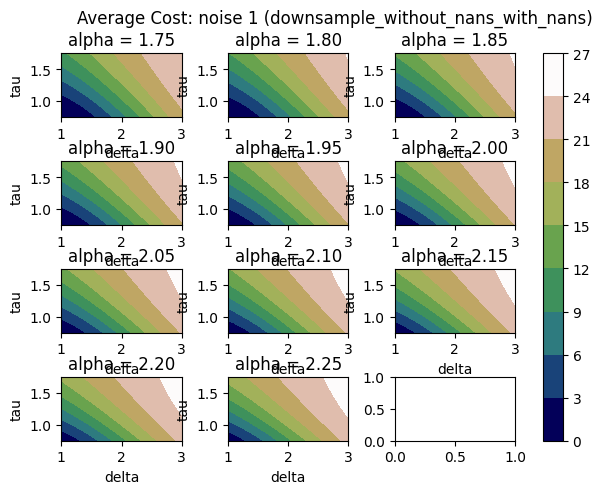

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_with_nans) = 4.030167351672717; at
    delta   tau  alpha
11    1.0  0.75    2.0


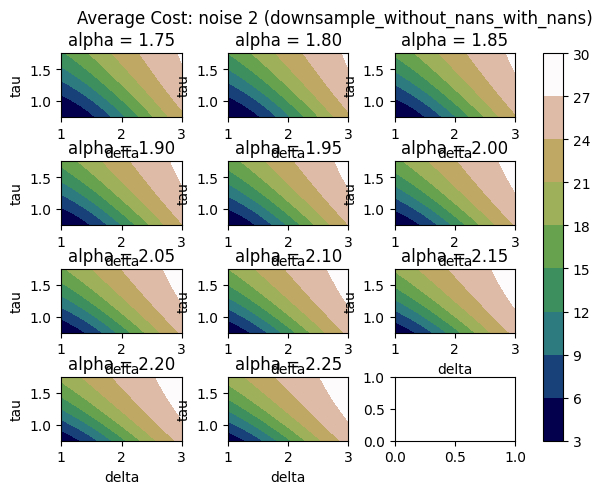

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_with_nans) = 8.898880658139776; at
    delta   tau  alpha
11    1.0  0.75    2.0


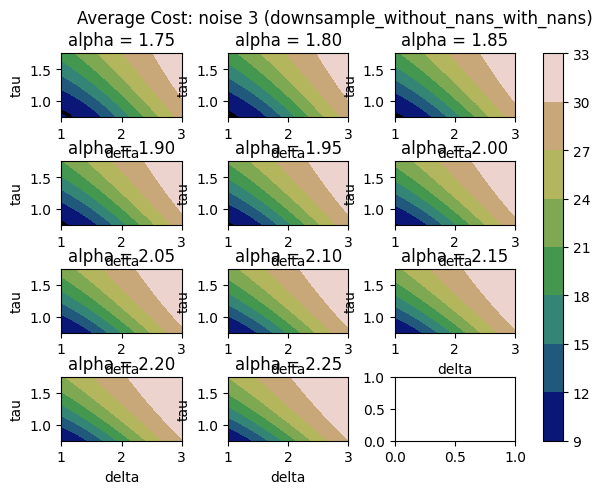

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_with_nans) = 16.119598490252052; at
    delta   tau  alpha
11    1.0  0.75    2.0


Minimal Cost for Average Cost: noise 5 (downsample_without_nans_with_nans) = 25.04453576346897; at
    delta   tau  alpha
11    1.0  0.75    2.0


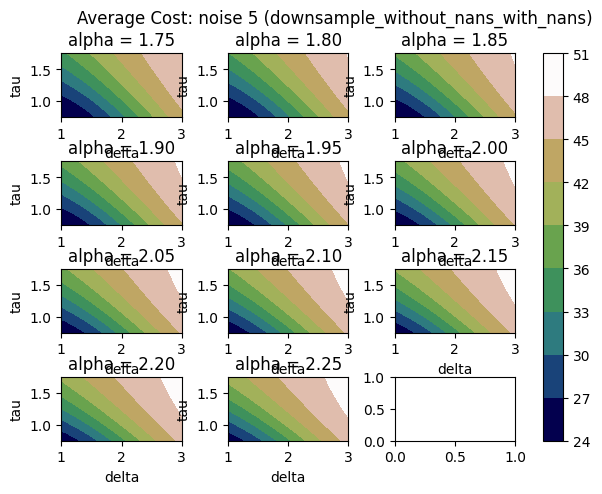

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_with_nans) = 36.36559043381673; at
    delta   tau  alpha
11    1.0  0.75    2.0


Minimal Cost for Average Cost: noise 7 (downsample_without_nans_with_nans) = 49.020032335838444; at
   delta   tau  alpha
9    1.0  0.75   1.95


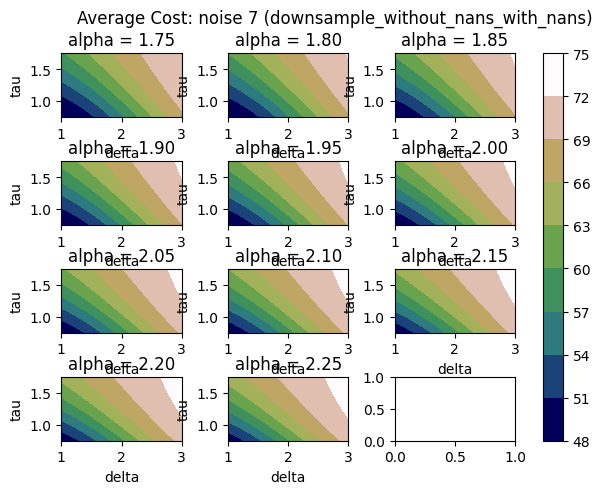

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_with_nans) = 64.20992564185269; at
     delta   tau  alpha
469   1.05  0.75    1.9


Minimal Cost for Average Cost: noise 9 (downsample_without_nans_with_nans) = 80.74146774653464; at
     delta  tau  alpha
487   1.05  0.8    1.8


Minimal Cost for Average Cost: noise 10 (downsample_without_nans_with_nans) = 98.88811126058715; at
     delta   tau  alpha
469   1.05  0.75    1.9


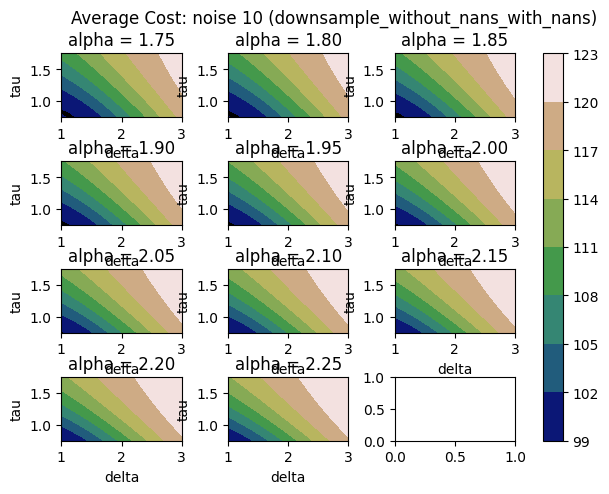

In [32]:
model_name = 'downsample_without_nans_with_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')


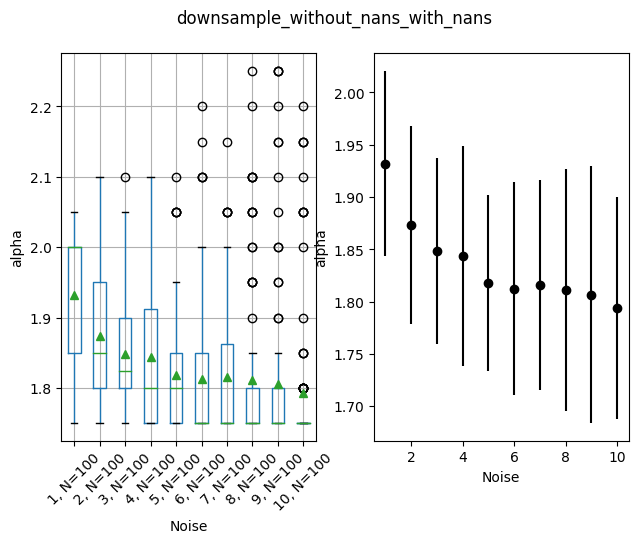

In [33]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

## Local Minima Analysis

### Downsample without missing data

In [34]:
model = df['model_name'].unique()[0]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_without_nans'


In [35]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [36]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta   tau  \
0         1         3    1.021250                 1.0  0.75   
1         1        29    1.069898                 1.0  0.75   
2         1         0    1.029770                 1.0  0.75   
3         1         1    0.954615                 1.0  0.75   
4         1         2    1.038659                 1.0  0.75   
...     ...       ...         ...                 ...   ...   
1801     10        71   95.417744  1.2500000000000002  0.75   
1802     10        73   98.820156  1.2500000000000002  0.75   
1803     10        77   94.856606  1.2500000000000002  0.75   
1804     10        63  103.169273  1.2500000000000002  0.75   
1805     10        89   98.672896  1.5000000000000004  0.75   

                   alpha  
0     1.9500000000000002  
1     1.9500000000000002  
2                    2.0  
3                    2.0  
4                    2.0  
...                  ...  
1801                1.75  
1802                1.75  
1803                1.75  
1804                 2.0  
1805                1.75  

[1806 rows x 6 columns]

In [37]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                          
                       count  mean       std  min  25%  50%   75%  max
noise                                                                 
1                      100.0  2.31  0.506423  1.0  2.0  2.0  3.00  3.0
2                      100.0  2.29  0.640312  1.0  2.0  2.0  3.00  3.0
3                      100.0  2.03  0.673525  1.0  2.0  2.0  2.00  3.0
4                      100.0  1.97  0.758188  1.0  1.0  2.0  2.25  4.0
5                      100.0  1.72  0.682834  1.0  1.0  2.0  2.00  3.0
6                      100.0  1.64  0.731955  1.0  1.0  1.5  2.00  4.0
7                      100.0  1.60  0.738549  1.0  1.0  1.0  2.00  4.0
8                      100.0  1.52  0.745085  1.0  1.0  1.0  2.00  4.0
9                      100.0  1.46  0.757721  1.0  1.0  1.0  2.00  4.0
10                     100.0  1.52  0.822413  1.0  1.0  1.0  2.00  5.0

#### Local minima at edges

In [38]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

noise iteration        cost delta                 tau  \
0         1         3    1.021250   1.0                0.75   
1         1        29    1.069898   1.0                0.75   
2         1         0    1.029770   1.0                0.75   
3         1         1    0.954615   1.0                0.75   
4         1         2    1.038659   1.0                0.75   
...     ...       ...         ...   ...                 ...   
1732     10        40   94.011613   1.0  0.9000000000000001   
1733     10        56   99.120778   1.0  0.9000000000000001   
1734     10        98   93.198965   1.0  0.9000000000000001   
1735     10        99  101.905219   1.0  0.9000000000000001   
1736     10        27   92.519595   1.0  0.9000000000000001   

                   alpha  
0     1.9500000000000002  
1     1.9500000000000002  
2                    2.0  
3                    2.0  
4                    2.0  
...                  ...  
1732                1.75  
1733                1.75  
1734                1.75  
1735                1.75  
1736                 1.8  

[874 rows x 6 columns]

In [39]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [40]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

noise iteration        cost               delta   tau  \
0         1         3    1.021250                 1.0  0.75   
1         1        29    1.069898                 1.0  0.75   
2         1         0    1.029770                 1.0  0.75   
3         1         1    0.954615                 1.0  0.75   
4         1         2    1.038659                 1.0  0.75   
...     ...       ...         ...                 ...   ...   
1801     10        71   95.417744  1.2500000000000002  0.75   
1802     10        73   98.820156  1.2500000000000002  0.75   
1803     10        77   94.856606  1.2500000000000002  0.75   
1804     10        63  103.169273  1.2500000000000002  0.75   
1805     10        89   98.672896  1.5000000000000004  0.75   

                   alpha  
0     1.9500000000000002  
1     1.9500000000000002  
2                    2.0  
3                    2.0  
4                    2.0  
...                  ...  
1801                1.75  
1802                1.75  
1803                1.75  
1804                 2.0  
1805                1.75  

[1054 rows x 6 columns]

In [41]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [42]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta   tau alpha
135       1         1    0.962737                1.05   0.8  1.75
136       1         4    0.948298                1.05   0.8  1.75
137       1         5    1.028365                1.05   0.8  1.75
138       1         9    1.016512                1.05   0.8  1.75
139       1        11    1.012349                1.05   0.8  1.75
...     ...       ...         ...                 ...   ...   ...
1800     10        57  101.239843  1.2500000000000002  0.75  1.75
1801     10        71   95.417744  1.2500000000000002  0.75  1.75
1802     10        73   98.820156  1.2500000000000002  0.75  1.75
1803     10        77   94.856606  1.2500000000000002  0.75  1.75
1805     10        89   98.672896  1.5000000000000004  0.75  1.75

[567 rows x 6 columns]

In [43]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                     tau                  
      count unique   top freq count unique   top freq
noise                                                
1        37      2  1.05   23    37      1   0.8   37
10       73      7   1.0   31    73      4  0.75   37
2        54      4  1.05   22    54      3   0.8   43
3        41      4  1.05   16    41      3   0.8   31
4        54      5  1.05   19    54      3   0.8   31
5        52      6  1.05   14    52      3   0.8   23
6        59      6   1.0   22    59      4  0.75   23
7        59      6   1.0   23    59      4  0.75   26
8        64      8   1.0   27    64      4  0.75   34
9        74      7   1.0   30    74      5  0.75   33

In [44]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost delta   tau               alpha
1395      8        49   57.646763   1.0  0.75  2.2500000000000004
1532      9        22   81.499800   1.0  0.75  2.2500000000000004
1593      9        13   77.234212  1.05  0.75  2.2500000000000004
1694     10        34  106.387242   1.0  0.75  2.2500000000000004
1695     10        92   91.898621   1.0  0.75  2.2500000000000004
1717     10        67   95.776306   1.0   0.8  2.2500000000000004
1746     10        23   99.790696  1.05  0.75  2.2500000000000004

In [45]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                    tau                  
      count unique  top freq count unique   top freq
noise                                               
10        4      2  1.0    3     4      2  0.75    3
8         1      1  1.0    1     1      1  0.75    1
9         2      2  1.0    1     2      1  0.75    2

In [46]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

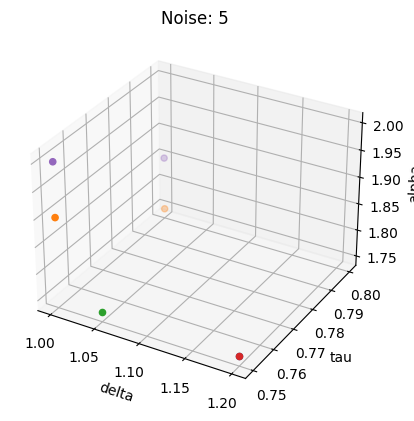

In [47]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

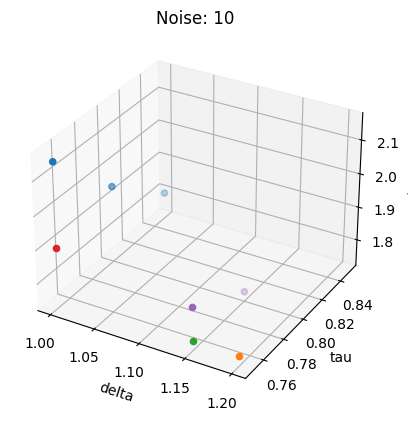

In [48]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

### Downsample with missing data

In [49]:
model = df['model_name'].unique()[1]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_with_nans'


In [50]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [51]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta   tau  \
0         1         3    1.059805                 1.0  0.75   
1         1        29    1.113083                 1.0  0.75   
2         1        70    1.021895                 1.0  0.75   
3         1         0    1.042180                 1.0  0.75   
4         1         1    0.952645                 1.0  0.75   
...     ...       ...         ...                 ...   ...   
1745     10        92   87.453210  1.2500000000000002  0.75   
1746     10        73   96.648960  1.3000000000000003  0.75   
1747     10        72  107.816479  1.3000000000000003   0.8   
1748     10        88   99.852888  1.3500000000000003  0.75   
1749     10        89  100.147424  1.5000000000000004  0.75   

                   alpha  
0     1.9500000000000002  
1     1.9500000000000002  
2     1.9500000000000002  
3                    2.0  
4                    2.0  
...                  ...  
1745                1.75  
1746                1.75  
1747                1.75  
1748                1.75  
1749                1.75  

[1750 rows x 6 columns]

In [52]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                          
                       count  mean       std  min  25%  50%   75%  max
noise                                                                 
1                      100.0  2.35  0.519810  1.0  2.0  2.0  3.00  3.0
2                      100.0  2.14  0.635959  1.0  2.0  2.0  3.00  3.0
3                      100.0  2.02  0.738275  1.0  1.0  2.0  3.00  3.0
4                      100.0  1.87  0.812217  1.0  1.0  2.0  2.25  4.0
5                      100.0  1.78  0.704674  1.0  1.0  2.0  2.00  4.0
6                      100.0  1.65  0.857233  1.0  1.0  1.0  2.00  4.0
7                      100.0  1.49  0.674125  1.0  1.0  1.0  2.00  3.0
8                      100.0  1.45  0.729951  1.0  1.0  1.0  2.00  4.0
9                      100.0  1.42  0.741007  1.0  1.0  1.0  2.00  4.0
10                     100.0  1.33  0.682464  1.0  1.0  1.0  1.00  4.0

#### Local minima at edges

In [53]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

noise iteration        cost delta                 tau  \
0         1         3    1.059805   1.0                0.75   
1         1        29    1.113083   1.0                0.75   
2         1        70    1.021895   1.0                0.75   
3         1         0    1.042180   1.0                0.75   
4         1         1    0.952645   1.0                0.75   
...     ...       ...         ...   ...                 ...   
1672     10        34  107.366870   1.0  0.9000000000000001   
1673     10        79   97.463040   1.0  0.9000000000000001   
1674     10        98   91.525049   1.0  0.9000000000000001   
1675     10        10  100.452513   1.0  0.9000000000000001   
1676     10        10  100.429958   1.0  0.9500000000000002   

                   alpha  
0     1.9500000000000002  
1     1.9500000000000002  
2     1.9500000000000002  
3                    2.0  
4                    2.0  
...                  ...  
1672                1.75  
1673                1.75  
1674                1.75  
1675  1.9000000000000001  
1676                1.75  

[883 rows x 6 columns]

In [54]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [55]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

noise iteration        cost               delta   tau  \
0         1         3    1.059805                 1.0  0.75   
1         1        29    1.113083                 1.0  0.75   
2         1        70    1.021895                 1.0  0.75   
3         1         0    1.042180                 1.0  0.75   
4         1         1    0.952645                 1.0  0.75   
...     ...       ...         ...                 ...   ...   
1744     10        85  105.378036  1.2500000000000002  0.75   
1745     10        92   87.453210  1.2500000000000002  0.75   
1746     10        73   96.648960  1.3000000000000003  0.75   
1748     10        88   99.852888  1.3500000000000003  0.75   
1749     10        89  100.147424  1.5000000000000004  0.75   

                   alpha  
0     1.9500000000000002  
1     1.9500000000000002  
2     1.9500000000000002  
3                    2.0  
4                    2.0  
...                  ...  
1744                1.75  
1745                1.75  
1746                1.75  
1748                1.75  
1749                1.75  

[1021 rows x 6 columns]

In [56]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [57]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta   tau alpha
144       1         4    0.929123                1.05   0.8  1.75
145       1         5    1.015665                1.05   0.8  1.75
146       1         6    0.996738                1.05   0.8  1.75
147       1         8    1.067392                1.05   0.8  1.75
148       1         9    1.036611                1.05   0.8  1.75
...     ...       ...         ...                 ...   ...   ...
1745     10        92   87.453210  1.2500000000000002  0.75  1.75
1746     10        73   96.648960  1.3000000000000003  0.75  1.75
1747     10        72  107.816479  1.3000000000000003   0.8  1.75
1748     10        88   99.852888  1.3500000000000003  0.75  1.75
1749     10        89  100.147424  1.5000000000000004  0.75  1.75

[605 rows x 6 columns]

In [58]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                     tau                  
      count unique   top freq count unique   top freq
noise                                                
1        38      2  1.05   23    38      1   0.8   38
10       80      9   1.0   31    80      5  0.75   45
2        46      4  1.05   21    46      3   0.8   32
3        46      4   1.1   16    46      3   0.8   24
4        54      5   1.1   17    54      3   0.8   25
5        57      6   1.0   20    57      4  0.75   27
6        68      7   1.0   27    68      5  0.75   30
7        69      7   1.0   31    69      5  0.75   31
8        72      8   1.0   33    72      4  0.75   40
9        75      8   1.0   32    75      5  0.75   42

In [59]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta   tau  \
1366      8        46   58.699574                 1.0  0.75   
1497      9        14   79.131043                 1.0  0.75   
1498      9        81   84.672457                 1.0  0.75   
1499      9        93   71.671469                 1.0  0.75   
1555      9        73   79.789915                1.05  0.75   
1556      9        86   81.409268                1.05  0.75   
1591      9        96   71.496242  1.1500000000000001  0.75   
1641     10        26   97.760013                 1.0  0.75   
1642     10        64  110.586752                 1.0  0.75   

                   alpha  
1366  2.2500000000000004  
1497  2.2500000000000004  
1498  2.2500000000000004  
1499  2.2500000000000004  
1555  2.2500000000000004  
1556  2.2500000000000004  
1591  2.2500000000000004  
1641  2.2500000000000004  
1642  2.2500000000000004

In [60]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                    tau                  
      count unique  top freq count unique   top freq
noise                                               
10        2      1  1.0    2     2      1  0.75    2
8         1      1  1.0    1     1      1  0.75    1
9         6      3  1.0    3     6      1  0.75    6

In [61]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

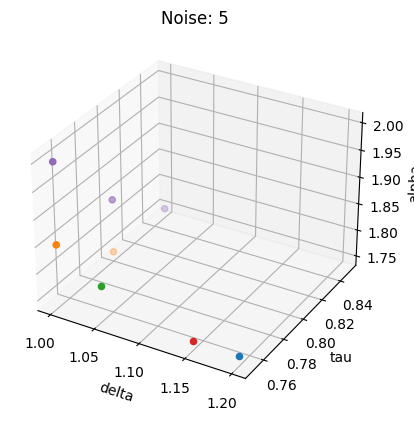

In [62]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

In [63]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()